# Оптимална бинаризация на цветни изображения, чрез линеен дискриминант на Фишер в цветовото (RGB) пространство

## Обработка на изображения

### Иван Арабаджийси

## **Задачата**

Вече познаваме някои модели за бинаризация на изображения, най-известния сред които е метода на `Otsu`. Тук ще разгледаме по-интересната задача за бинаризация на цветни изображения използвайки линеен дискриминант на Фишер. Разглеждаме линейният дискриминант на Фишър в контекста на редукция на измерения. Взимаме `D-измерен` вектор и го проектираме върху `D'` измерен. В случая на `D'=1` можем просто да изберем някаква граница `(threshold)` t и да класифицираме всички пиксели >= t като фон, а останалите като обект. В полутоновите изображения тази задача изглежда така.

За всяко изображение имамe множество H = {C<sub>1</sub>,C<sub>2</sub>} = {h<sub>1</sub>,h<sub>2</sub>, ..., h<sub>N</sub>}, където n<sub>1</sub> + n<sub>2</sub> = N, N е броят на интензитетите, а n<sub>1</sub> и n<sub>2</sub> са съответно кардиналностите на C<sub>1</sub> и C<sub>2</sub>. Образуваме множество X = {x<sub>1</sub>,x<sub>2</sub>, ..., x<sub>N</sub>}, където x<sub>i</sub> = v . h<sub>i</sub>. v e вектор стълб с размерност n. Той е векторът, върху който се проектират точките от началното множество (пикселите).

Но как преценяме дали един такъв вектор е добър избор за вектор на проекция? Една функция, която ни дава добра оценка е **J(v) = $\frac{|m_1 - m_2|^2}{s_1^2+s2^2}$**. $m_i$ e медианата на елементите от множеството $X_i$, a $S_W=s_1^2+s2^2$ e вътрешно класовата дисперсия. Вектор v, който максимизира J(v), ще наричаме оптимална проекция на Фишър. Той максимизира разстоянието между медианите и минимизира дисперсията на всеки един клас. Оптималната проекция $v_{opt} = arg max J(v)$   

Сега приемаме, че работим с полутоново изображение с L нива на сивото [0, 1, ..., L - 1]. Броят пиксели с интензитет *i* ще бележим с $n_i$, a общия брой пиксели е N = $n_0$ + $n_1$ + ... + $n_{L - 1}$. Вероятността интензитет i да се срещне в изображението определяме като $p_i = \frac{n_i}{N}, p_i >= 0, \sum_{i=1}^{L-1}, p_i = 1$. Приемаме, че пикселите ни са разделени в два класа $C_1 и C_2$ от граница t - някой от интензитетите на сивото. $C_1$ e множеството от пиксели с интензитет [0, 1, ..., k], a останалите са в $C_2$. Тези два класа обикновено са пикселите от фона и пикселите от обекта. Изчисляваме вероятностите като $w_1(k) = \sum_{i=1}^{k}p_i, w_2(k) = 1 - w_1(k)$. Медианите: $m_1(k) = \sum_{i=1}^{k}\frac{ip_i}{w_1}, m_2(k) = \sum_{i=k+1}^{L - 1} \frac{ip_i}{w_2}$ и дисперсии $\sigma_1^2 = \sum_{i=0}^{k}\frac{(i - m_1)^2p_i}{w_1}, \sigma_2^2 = \sum_{i=0}^{k}\frac{(i - m_2)^2p_i}{w_2}$.

Алгоритъмът, които използаме за намиране на оптимално v.

1. Нека maxλ = 0, е най-голямата стойност на фитнес функциятa $λ(k) = σ_W^{−2} ∗(m_2(k) − m_1(k))^2$. <br>
$σ_w^2 = w_1(k)σ_1^2 + w_2(k)σ_2^2$
2. For k = 1 to maximum of gray intensities (L)
3. Пресмятаме стойносттна на λ(k) oтговаряща за интензитет k. <br>
Ako maxλ < λ(k), maxλ = λ(k), $T_{opt}$ = k

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def prob(i, hist, N):
    return hist[i] / N

def classProbabilities(k, hist, N):
    w1 = 0
    for i in range(k):
        w1 += prob(i, hist, N)
    w2 = 1 - w1
    return w1, w2

def meanGrayLevels(k, w1, w2, L, hist, N):
    m1, m2 = 0, 0
    for i in range(L):
        if(w1 != 0 and w2 != 0):
            pi = prob(i, hist, N)
            if i <= k:
                m1 += i * pi / w1
            else:
                m2 += i * pi / w2
    return m1, m2

def withinClassVariangce(k: int, w1, w2, m1, m2, L, hist, N):
    sigma1, sigma2 = 0, 0
    for i in range(L):
        pi = prob(i, hist, N)
        if(w1 != 0 and w2 != 0):
            if i <= k:
                sigma1 += ((i - m1) ** 2) * pi / w1
            else:
                sigma2 += ((i - m2) ** 2) * pi / w2
    return sigma1, sigma2

def withinClassScatter(k: int, w1, w2, m1, m2, L, hist, N):
    sigma1, sigma2 = withinClassVariangce(k, w1, w2, m1, m2, L, hist, N)
    return w1 * sigma1 + w2 * sigma2

def λ(k: int, hist, N, L):
    w1, w2 = classProbabilities(k, hist, N)
    m1, m2 = meanGrayLevels(k, w1, w2, L, hist, N)
    wcs = withinClassScatter(k, w1, w2, m1, m2, L, hist, N)
    if wcs == 0:
        return 0
    return (wcs ** -1) * ((m2-m1) ** 2) 

def findOptT(img):
    L = 256
    hist = np.zeros((L,), dtype=np.uint32)
    r, c= img.shape
    N = r * c
    for i in range(r):
        for j in range(c):
            hist[img[i,j]] += 1

    plt.plot(hist)
    maxλ = 0
    for k in range(1, L):
        λk = λ(k, hist, N, L)
        if λk > maxλ:
            maxλ = λk
            Topt = k
    return Topt

In [3]:
def binarizationAndComparisonToOtsu(name: str):
    img = cv2.imread(name, cv2.IMREAD_GRAYSCALE)

    t, bin_otsu = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    Topt = findOptT(img) 
    print("Otsu: ", t)
    print("Fisher's linear discreminant: ", Topt)

    bin_t = img.copy()
    bin_t[bin_t < Topt] = 0
    bin_t[bin_t >= Topt] = 255

    plt.figure(figsize=(40, 10))
    plt.imshow(np.concatenate((img, bin_otsu, bin_t), axis=1), 'gray')

Otsu:  118.0
Fisher's linear discreminant:  144


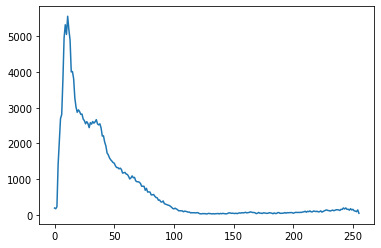

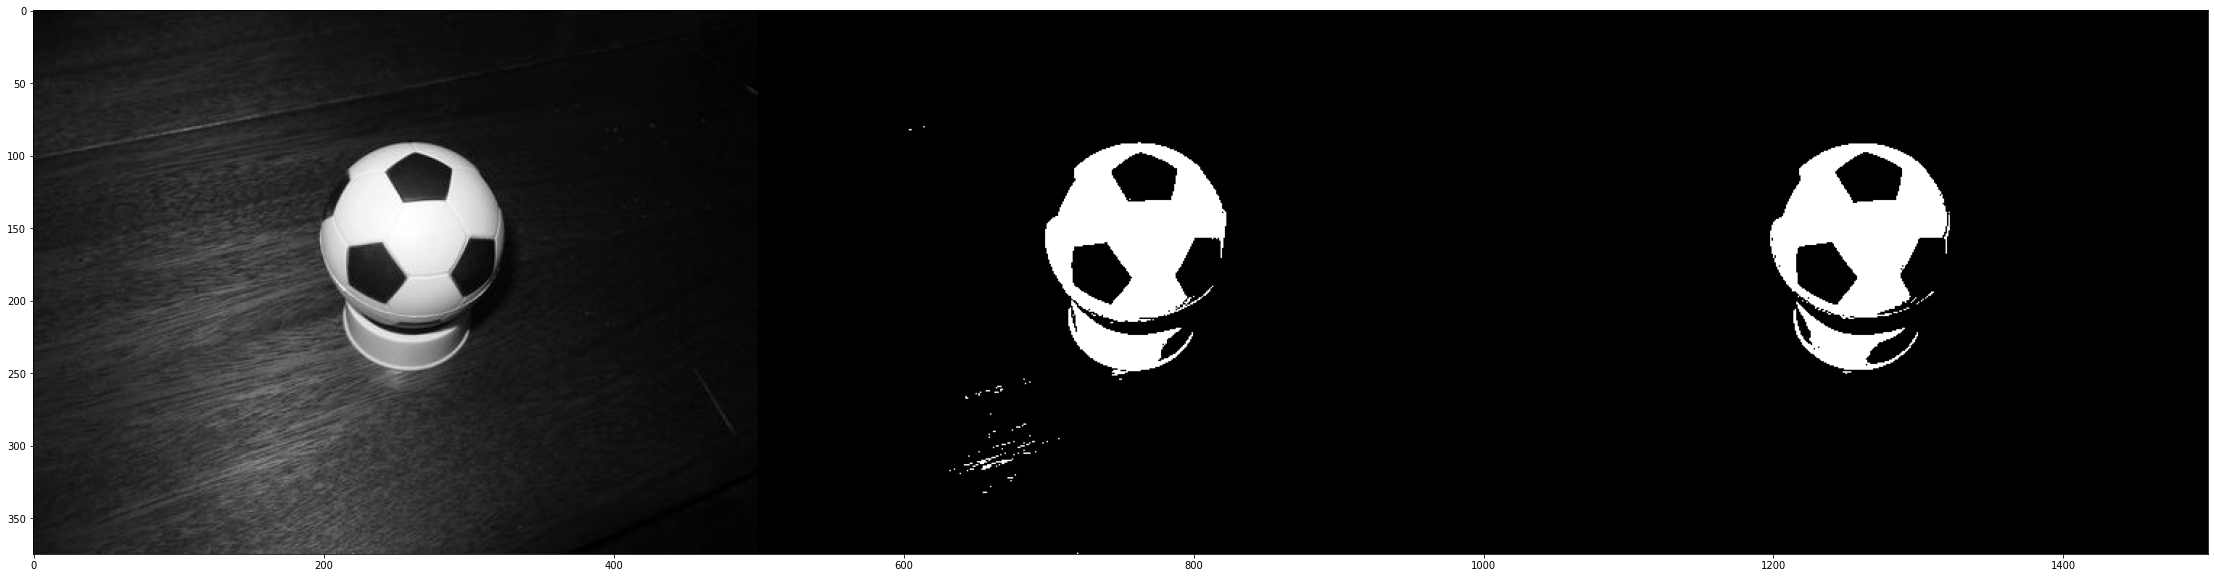

In [4]:
binarizationAndComparisonToOtsu("ball.jpg")

Otsu:  137.0
Fisher's linear discreminant:  131


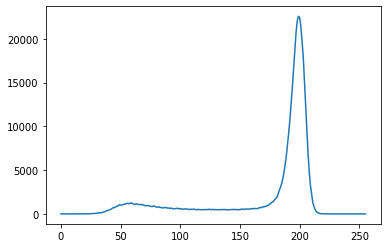

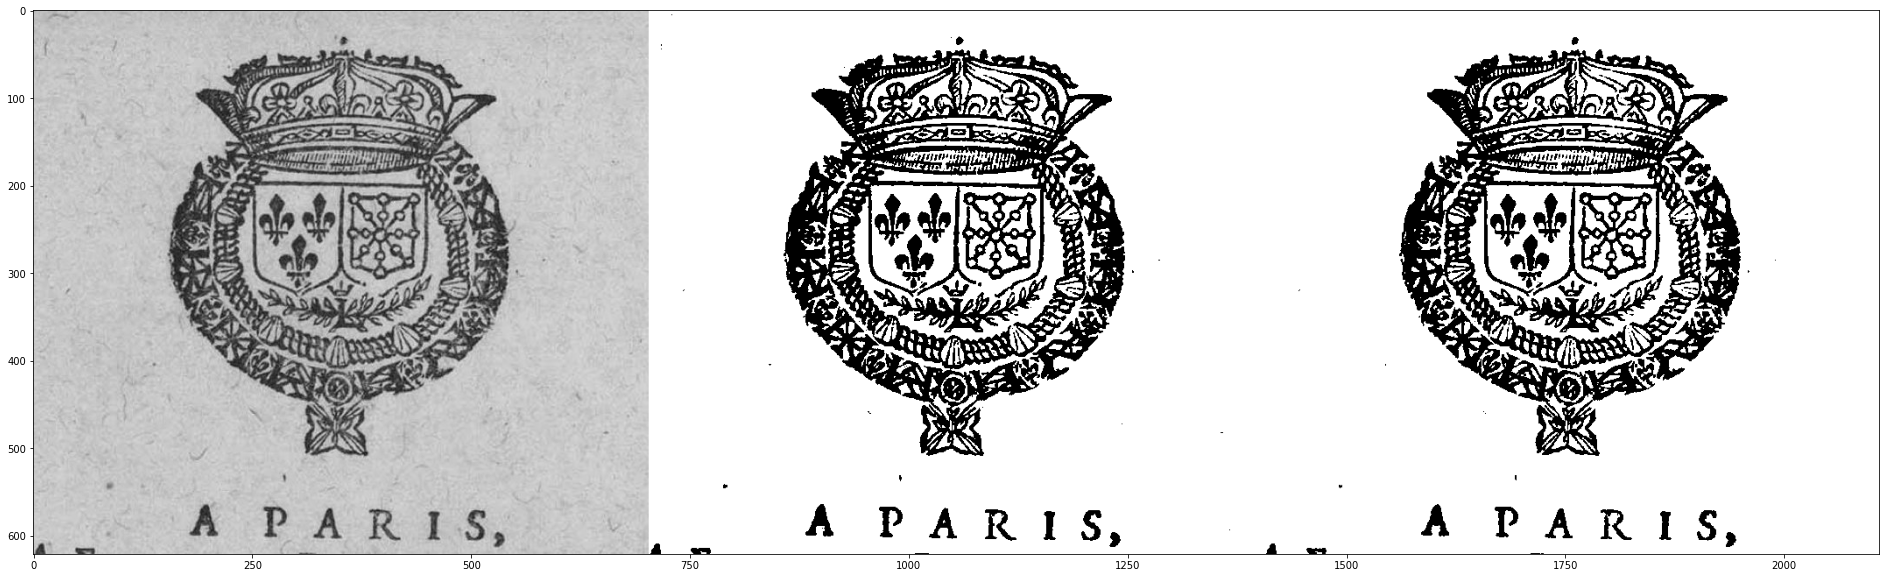

In [5]:
binarizationAndComparisonToOtsu("print.jpg")

Otsu:  117.0
Fisher's linear discreminant:  109


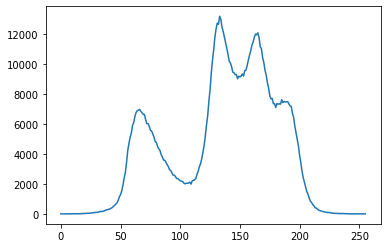

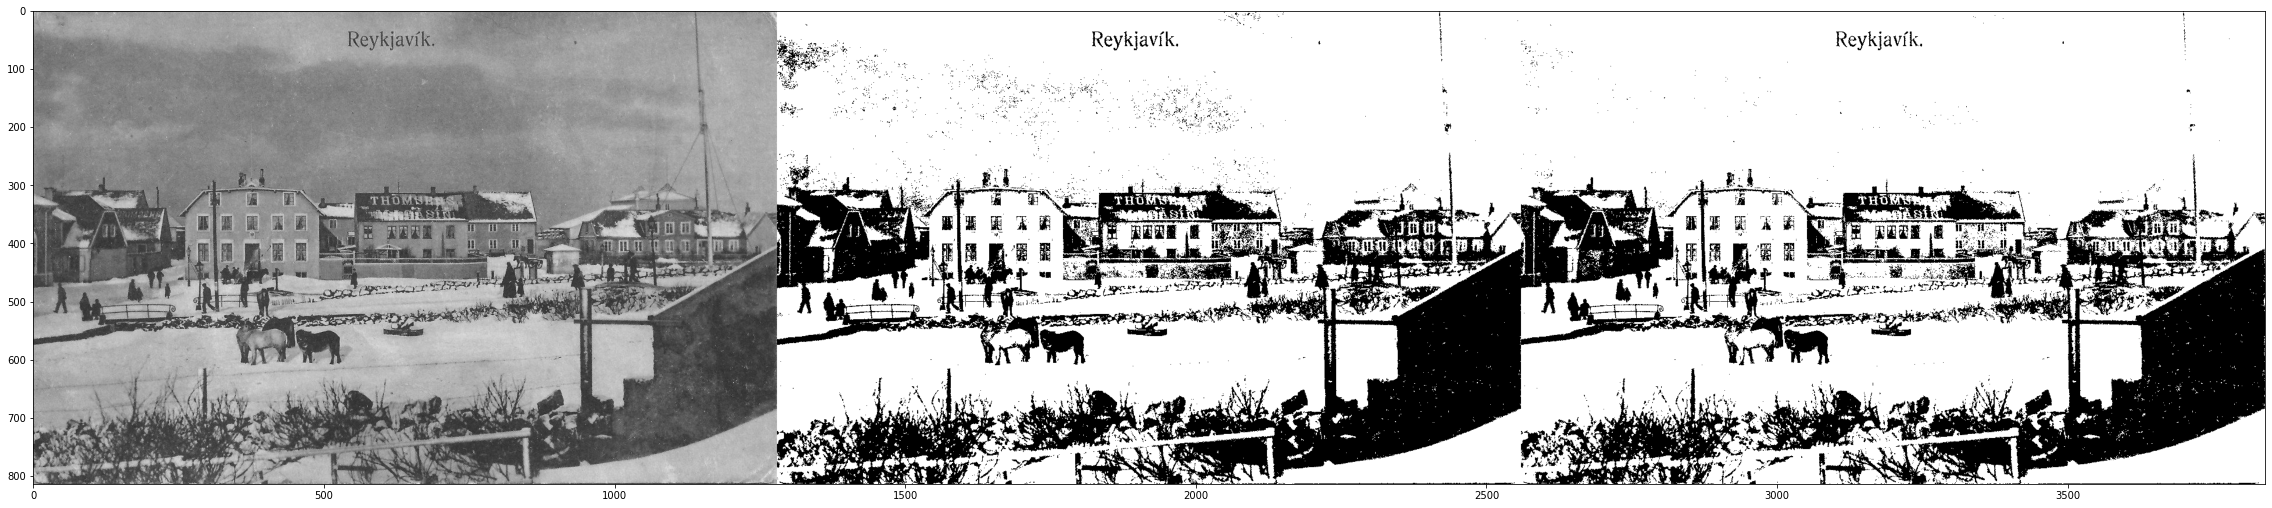

In [6]:
binarizationAndComparisonToOtsu("reykjavik.jpg")

Otsu:  134.0
Fisher's linear discreminant:  130


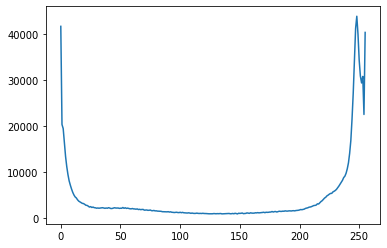

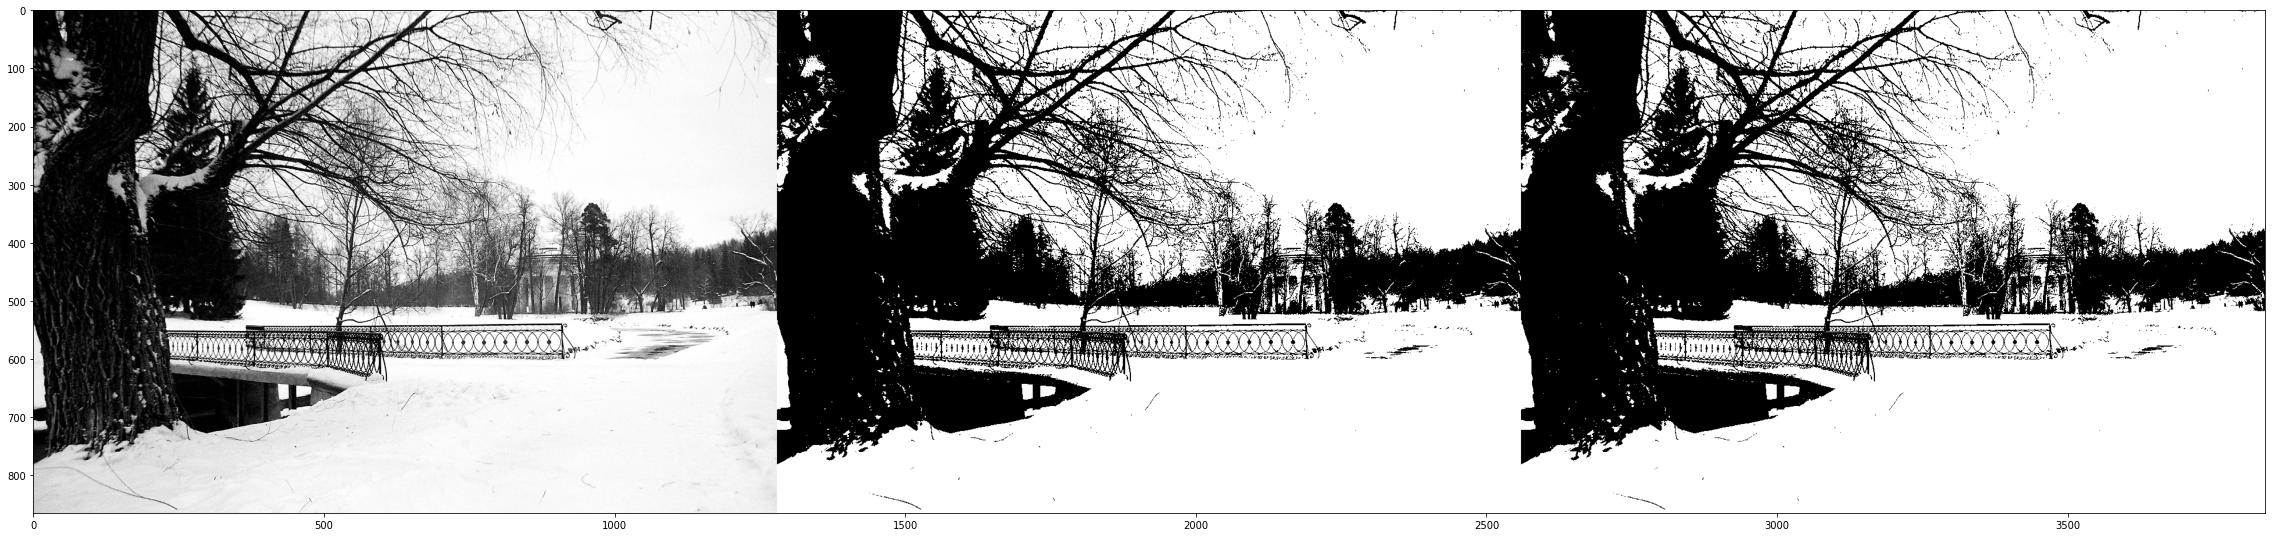

In [7]:
binarizationAndComparisonToOtsu("Pavlovsk_Railing_of_bridge_Yellow_palace_Winter.jpg")

## Плюсове и минуси?

- Лесен за имплементация
- Отделя малки обекти от фона относително добре и надеждно.

## А сега да се пренесем в цветното RGB пространство.
Тъй като алгоритъмът итерира през всички възможни интензитети на сивото за да максимизира фитнес функцията и да избере най-добрата граница, той не е приложим в този си вид, когато говорим за цветното RGB пространство. Там вече имаме три канала вместо един. Това означава, че нивата на интензитет стават $255^3$ и не можем да определим оптималния вектор с пробване. 

Да разгледаме някои основни идеи:
1. Преобразуване на цветното изображение в полутоново и работа върху него.
2. Разделяне на трите канала, намиране на граници върху всеки един поотделно и образуване на нова граница като обединим трите с логическо &&
3. Резултата получаваме, когато комбинираме бинаризираните изображения на трите разделени канала и изображението преоразувано в полутоново.


Otsu:  117.0
Fisher's linear discreminant:  104


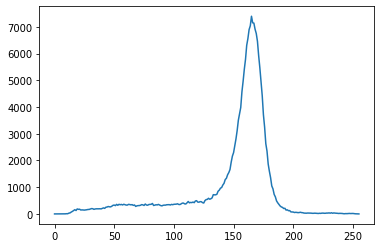

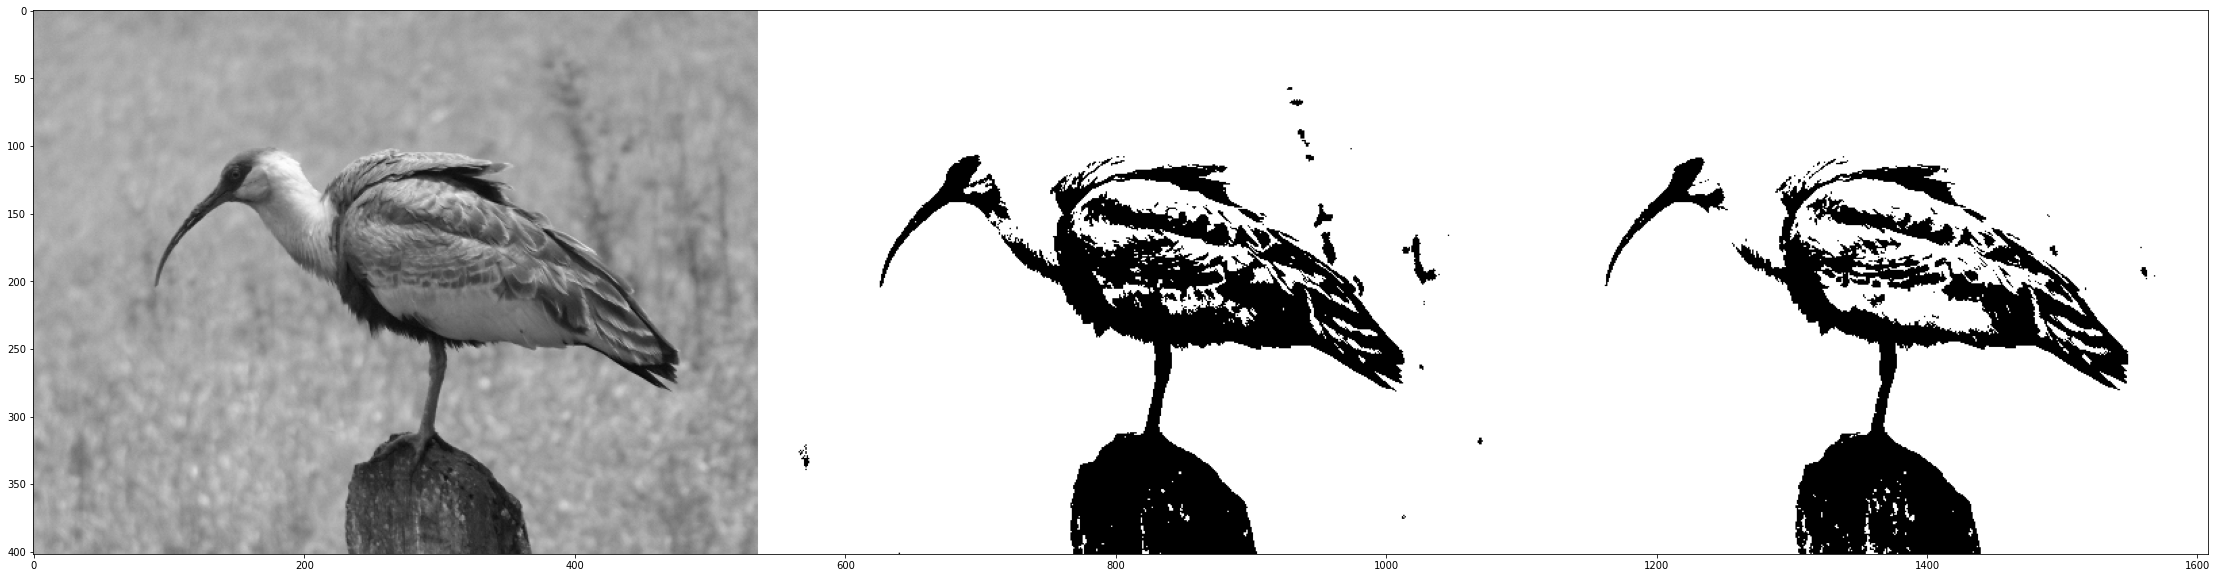

In [8]:
name = "DgR9V.jpg"
binarizationAndComparisonToOtsu(name)

### **Втора идея**

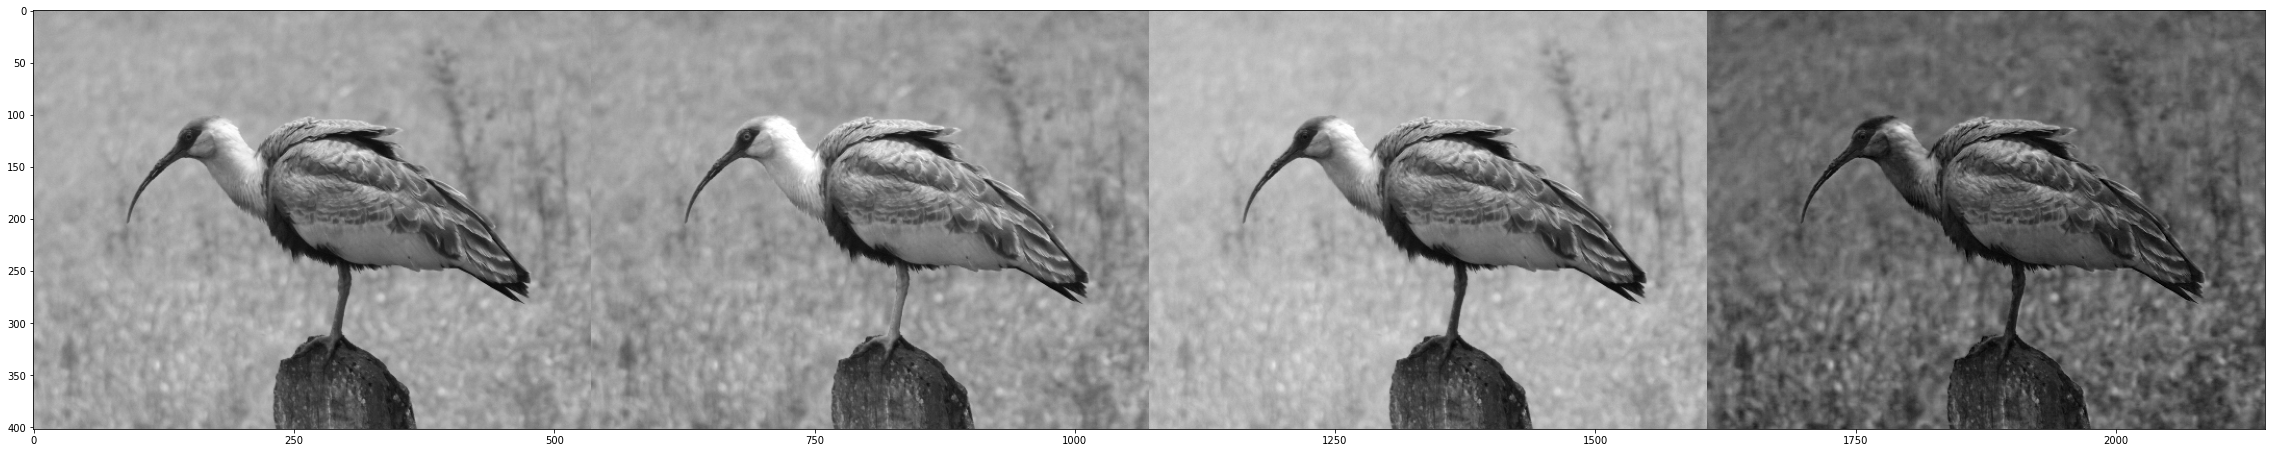

In [9]:
imgGray = cv2.imread(name, cv2.IMREAD_GRAYSCALE)
img = cv2.cvtColor(cv2.imread(name), cv2.COLOR_BGR2RGB)
r, c, _ = img.shape
imgRed = imgGray.copy()
imgGreen = imgGray.copy()
imgBlue = imgGray.copy()
for i in range(r):
    for j in range(c):
        imgRed[i][j] = img[i][j][0]
        imgGreen[i][j] = img[i][j][1]
        imgBlue[i][j] = img[i][j][2]

plt.figure(figsize=(40, 10))
plt.imshow(np.concatenate((imgGray,imgRed,imgGreen,imgBlue),axis=1), 'gray') 

[91, 117, 236]


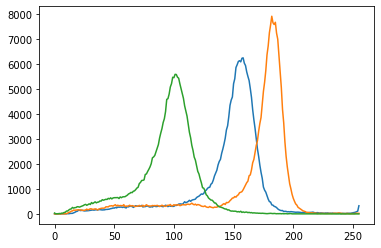

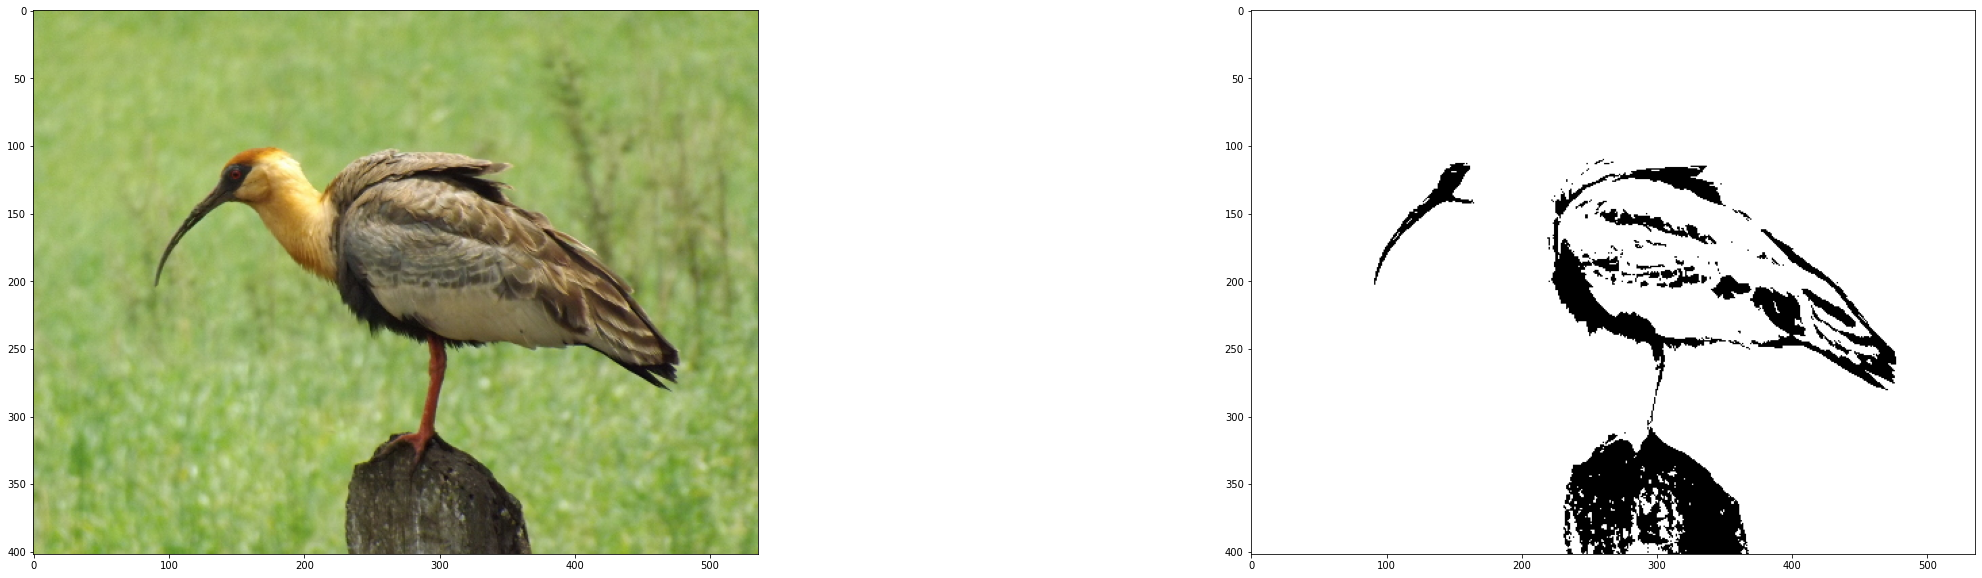

In [10]:
imagesRGB=[imgRed,imgGreen,imgBlue]
Topt = list(map(lambda x: findOptT(x), imagesRGB))

print(Topt)
bin_t = imgGray.copy()
for i in range(r):
    for j in range(c):
        if img[i][j][0] < Topt[0] and img[i][j][1] < Topt[1] and img[i][j][2] < Topt[2]:
            bin_t[i][j] = 0
        else:
            bin_t[i][j] = 255

plt.figure(figsize=(40, 10))
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(bin_t, 'gray')

### **Трета идея**

104
91
117
236


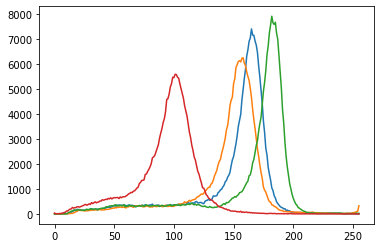

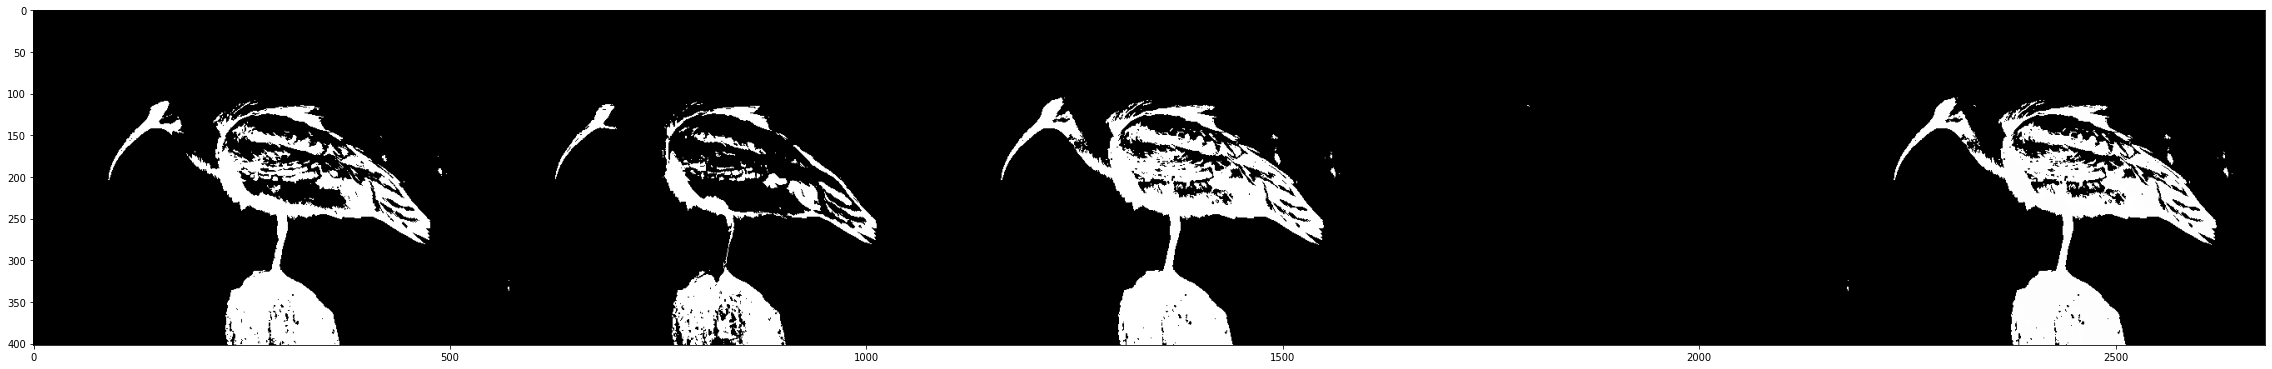

In [11]:
def imageToBinary(img):
    t = findOptT(img) 
    print(t)
    bin = img.copy()
    bin[bin < t] = 0
    bin[bin >= t] = 255
    if t < 124:
        bin = 255 - bin 
    return bin

images=[imgGray, imgRed, imgGreen, imgBlue]
imagesBin = list(map(imageToBinary, images))
bin = imagesBin[0] + imagesBin[1] + imagesBin[2] + imagesBin[3]; 
plt.figure(figsize=(40, 10))
plt.imshow(np.concatenate((imagesBin[0], imagesBin[1], imagesBin[2],imagesBin[3],bin), axis=1), 'gray')

## Заключение

Линейният дискриминант на Фишър дава един интересен поглед върху задачата за бинаризация на изборажение. Методът е бърз, отделя дребни предмети добре и не използва допълнителни параметри за тегло. Резултатите върху изображения в цветното пространство също не са лоши, но все пак трябва да се има предвид, че използването на предложения алгоритъм в бинаризация на няколко нива и в цветно пространсто все още се изучават.

## Използвани материали
1. [An illustrative introduction to Fisher's Linear Discriminant](https://sthalles.github.io/fisher-linear-discriminant/)
2. [Thresholding Based on Fisher Linear Discriminant](https://www.researchgate.net/publication/274337506_Thresholding_Based_on_Fisher_Linear_Discriminant)
3. [Fischer’s Linear Discriminant Analysis in Python from scratch](https://ai.plainenglish.io/fischers-linear-discriminant-analysis-in-python-from-scratch-bbe480497504)
4. [A thresholding Method for Color Image Binarization](https://www.academia.edu/9870895/A_thresholding_Method_for_Color_Image_Binarization)